In [1]:
!pip install fastf1

In [3]:
import fastf1
from fastf1 import plotting
import os
import logging
from sqlalchemy import create_engine, inspect
import pandas as pd
# Silence FastF1 warnings
logging.getLogger('fastf1').setLevel(logging.CRITICAL)

# Cache setup
cache_dir = 'cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
fastf1.Cache.enable_cache(cache_dir)


class SectorStats:
    def __init__(self, df, sector_col, driver_col='Driver'):
        self.df = df
        self.sector_col = sector_col
        self.driver_col = driver_col

    def min_time(self):
        min_idx = self.df[self.sector_col].idxmin()
        return self.df.loc[min_idx, self.driver_col], self.df.loc[min_idx, self.sector_col]

    def max_time(self):
        max_idx = self.df[self.sector_col].idxmax()
        return self.df.loc[max_idx, self.driver_col], self.df.loc[max_idx, self.sector_col]

    def mean_time(self):
        return self.df[self.sector_col].mean()

    def all_times(self):
        return self.df.groupby(self.driver_col)[self.sector_col].mean().reset_index().sort_values(by=self.sector_col)


class SpeedStats:
    def __init__(self, df, speed_col, driver_col='Driver'):
        self.df = df
        self.speed_col = speed_col
        self.driver_col = driver_col

    def max_speed(self):
        max_idx = self.df[self.speed_col].idxmax()
        return self.df.loc[max_idx, self.driver_col], self.df.loc[max_idx, self.speed_col]

    def min_speed(self):
        min_idx = self.df[self.speed_col].idxmin()
        return self.df.loc[min_idx, self.driver_col], self.df.loc[min_idx, self.speed_col]

    def mean_speed(self):
        return self.df[self.speed_col].mean()

    def all_speeds(self):
        return self.df.groupby(self.driver_col)[self.speed_col].mean().reset_index().sort_values(by=self.speed_col, ascending=False)


class TyreStrategyAnalysis:
    def __init__(self, df):
        self.df = df

    def tyre_usage_by_driver(self):
        return self.df.groupby(['Driver', 'Compound'])['LapNumber'].count().reset_index(name='LapsOnTyre')

    def average_tyre_life(self):
        return self.df.groupby('Compound')['TyreLife'].mean().reset_index(name='AvgTyreLife')

    def stint_summary(self):
        return self.df.groupby(['Driver', 'Stint', 'Compound'])['LapNumber'].count().reset_index(name='StintLength')


class PitStopAnalysis:
    def __init__(self, df):
        self.df = df

    def pit_stop_count(self):
        return self.df[self.df['PitInTime'].notna()].groupby('Driver').size().reset_index(name='PitStops')

    def pit_lap_numbers(self):
        return self.df[self.df['PitInTime'].notna()].groupby('Driver')['LapNumber'].apply(list).reset_index()


class StintPerformance:
    def __init__(self, df):
        self.df = df

    def average_lap_time_by_stint(self):
        return self.df.groupby(['Driver', 'Stint'])['LapTime'].mean().reset_index()

    def performance_by_compound(self):
        return self.df.groupby(['Compound'])['LapTime'].mean().sort_values().reset_index()


def get_race_winner(laps_df):
    final_lap = laps_df['LapNumber'].max()
    winner_row = laps_df[(laps_df['LapNumber'] == final_lap) & (laps_df['Position'] == 1)].iloc[0]
    return winner_row['Driver']


def top_speeds(df):
    speed_cols = ['SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']
    return {col: df.loc[df[col].idxmax(), ['Driver', col]].to_dict() for col in speed_cols if col in df.columns}


class RaceAnalysis:
    # Static PostgreSQL credentials
    DB_USER = 'postgres'
    DB_PASS = 'postgres'
    DB_HOST = 'localhost'
    DB_PORT = '5432'
    DB_NAME = 'postgres'

    def __init__(self, year, country_name, session_type='R'):
        try:
            self.session = fastf1.get_session(year, country_name, session_type)
            self.session.load()
            self.laps = self.session.laps

            table_name = f"f1_{year}_{country_name.lower().replace(' ', '_')}_{session_type.lower()}"
            self._push_to_postgres_if_needed(table_name)

        except fastf1.core.DataNotLoadedError:
            raise ValueError(f"Data for {country_name} {year} {session_type} session not found.")
        except Exception as e:
            raise RuntimeError(f"An error occurred while loading the session: {e}")

    def _push_to_postgres_if_needed(self, table_name):
        engine_url = (
            f'postgresql://{self.DB_USER}:{self.DB_PASS}@{self.DB_HOST}:{self.DB_PORT}/{self.DB_NAME}'
        )
        engine = create_engine(engine_url)
        inspector = inspect(engine)
        existing_tables = inspector.get_table_names()
        if table_name in existing_tables:
            print(f"Table '{table_name}' already exists. Skipping insert.")
            return
        df = self.laps.copy()
        df = df.drop(columns=['Telemetry', 'CarData', 'PositionData'], errors='ignore')
        for col in ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Time','PitOutTime','PitInTime','Sector1SessionTime','Sector2SessionTime','Sector3SessionTime','LapStartTime']:
            if col in df.columns and pd.api.types.is_timedelta64_dtype(df[col]):
                df[col] = df[col].astype(str)
        df.reset_index(drop=True, inplace=True)
        df.to_sql(table_name, engine, if_exists='replace', index=False)
        print(f"Inserted session data into table '{table_name}' ")

    def get_sector_stats(self, sector_name):
        return SectorStats(self.laps, sector_name)

    def get_speed_stats(self, speed_name):
        return SpeedStats(self.laps, speed_name)

    def lap_time_summary(self):
        best_lap = self.laps.pick_fastest()
        worst_lap = self.laps[self.laps['LapTime'] == self.laps['LapTime'].max()]
        avg_lap = self.laps['LapTime'].mean()
        return {
            'best': (best_lap['Driver'], best_lap['LapTime']),
            'worst': (worst_lap.iloc[0]['Driver'], worst_lap.iloc[0]['LapTime']),
            'average': avg_lap
        }

    def position_tracking(self):
        return self.laps.groupby(['Driver', 'LapNumber'])['Position'].mean().reset_index()

    def tyre_strategy(self):
        return TyreStrategyAnalysis(self.laps)

    def pit_stops(self):
        return PitStopAnalysis(self.laps)

    def stint_performance(self):
        return StintPerformance(self.laps)

    def winner(self):
        return get_race_winner(self.laps)

    def top_speeds_all(self):
        return top_speeds(self.laps)
analysis = RaceAnalysis(2024, 'miami')
analysis.lap_time_summary()

Table 'f1_2024_miami_r' already exists. Skipping insert.


{'best': ('PIA', Timedelta('0 days 00:01:30.634000')),
 'worst': ('SAI', Timedelta('0 days 00:02:28.743000')),
 'average': Timedelta('0 days 00:01:36.003386980')}

In [4]:
import psycopg2

def union_view():
    conn = psycopg2.connect(
        host='localhost',
        port=5432,
        dbname='postgres',
        user='postgres',
        password='postgres'
    )
    cursor = conn.cursor()

    # Get all F1-related tables
    cursor.execute("""
        SELECT tablename
        FROM pg_catalog.pg_tables
        WHERE schemaname = 'public' AND tablename LIKE 'f1\\_%\\_%\\_%';
    """)
    all_tables = set(row[0] for row in cursor.fetchall())

    # Check if the view exists and get its definition
    cursor.execute("""
        SELECT definition
        FROM pg_views
        WHERE viewname = 'f1_all_sessions';
    """)
    result = cursor.fetchone()
    if result:
        current_def = result[0]
        existing_tables = set()
        for table in all_tables:
            if table in current_def:
                existing_tables.add(table)
    else:
        existing_tables = set()

    new_tables = all_tables - existing_tables

    if not new_tables:
        print(" View is already up to date. No changes made.")
        conn.close()
        return

    all_to_union = existing_tables | new_tables
    union_query = "CREATE OR REPLACE VIEW f1_all_sessions AS\n"
    union_query += "\nUNION ALL\n".join(
        [f"SELECT *, '{table}' AS source FROM {table}" for table in sorted(all_to_union)]
    ) + ";"

    cursor.execute(union_query)
    conn.commit()
    conn.close()

    print(f" View `f1_all_sessions` updated. Total tables: {len(all_to_union)}")
        # After pushing data to PostgreSQL
union_view()


 View is already up to date. No changes made.


In [5]:
#VISUALIZATIONS
# Import required libraries
import fastf1
import logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colormaps
from matplotlib.collections import LineCollection
from fastf1 import plotting

# Disable FastF1 logging to reduce console clutter
fastf1.logger.set_log_level(logging.CRITICAL)

# Class: DriverLapData

'''
This class loads and stores telemetry data for a specific driver,
lap, session, and event. It supports selecting either a specific
lap number or the fastest lap automatically.
'''
class DriverLapData:
    def __init__(self, year, gp, event, lap_number=None, driver_code=None):
        self.year = year
        self.gp = gp
        self.event = event
        self.lap_number = lap_number
        self.driver_code = driver_code
        self.session = None
        self.lap = None
        self.car_data = None
        self.telemetry = None
        self.load_data()

    def load_data(self):
        # Load the race session
        self.session = fastf1.get_session(self.year, self.gp, self.event)
        self.session.load()

        # Get all laps of the selected driver
        driver_laps = self.session.laps.pick_driver(self.driver_code)

        # Pick the specified lap or the fastest one
        if self.lap_number is not None:
            self.lap = driver_laps[driver_laps['LapNumber'] == self.lap_number].iloc[0]
        else:
            self.lap = driver_laps.pick_fastest()

        # Load car telemetry and add distance information
        self.car_data = self.lap.get_car_data()
        self.telemetry = self.lap.get_telemetry()

# Class: LapComparison

'''
This class plots lap telemetry data to compare two laps (e.g., same driver in two years).
It supports plotting speed, RPM, throttle, brake, etc.
'''
class LapComparison:
    def __init__(self, driver1_data: DriverLapData, driver2_data: DriverLapData):
        self.driver1_data = driver1_data
        self.driver2_data = driver2_data
        plotting.setup_mpl()

    def plot_comparison(self, x_measure='Time', y_measures_labels=None):
        if y_measures_labels is None:
            y_measures_labels = [
                ("Speed", "Speed [km/h]"),
                ("RPM", "RPM [#]"),
                ("nGear", "Gear [#]"),
                ("Throttle", "Throttle [%]"),
                ("Brake", "Brake [%]")
            ]

        fig, ax = plt.subplots(len(y_measures_labels), figsize=(14, 10))
        color1 = "red"
        color2 = "blue"

        # Plot each telemetry parameter as a subplot
        for i, (y_measure, ylabel) in enumerate(y_measures_labels):
            ax[i].plot(self.driver1_data.car_data[x_measure], self.driver1_data.car_data[y_measure], color=color1)
            ax[i].plot(self.driver2_data.car_data[x_measure], self.driver2_data.car_data[y_measure], color=color2)
            ax[i].set_ylabel(ylabel)
            if i < len(y_measures_labels) - 1:
                ax[i].get_xaxis().set_ticklabels([])  # Hide x-ticks for top subplots

        # Align Y-axis labels and add legend
        fig.align_ylabels()
        fig.legend([
            f"{self.driver1_data.driver_code} - {self.driver1_data.gp} {self.driver1_data.year} Lap {self.driver1_data.lap_number or 'Fastest'}",
            f"{self.driver2_data.driver_code} - {self.driver2_data.gp} {self.driver2_data.year} Lap {self.driver2_data.lap_number or 'Fastest'}"
        ])
        ax[-1].set_xlabel("Time in sec/min")
        plt.subplots_adjust(left=0.06, right=0.99, top=0.9, bottom=0.05)
        plt.show()

# Class: TrackMap

'''
This class provides two types of 2D track visualizations:
- Gear shift map (with colors indicating gear used)
- Speed map (with colors indicating velocity)
'''
class TrackMap:
    def __init__(self, driver_data: DriverLapData):
        self.driver_data = driver_data
        self.telemetry = driver_data.telemetry
        self.lap = driver_data.lap
        self.event = driver_data.session.event

    def _get_segments(self, x, y):
        # Convert telemetry x, y positions into line segments
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        return np.concatenate([points[:-1], points[1:]], axis=1)

    def plot_gear(self):
        # Extract data
        x = self.telemetry['X'].to_numpy()
        y = self.telemetry['Y'].to_numpy()
        gear = self.telemetry['nGear'].to_numpy().astype(float)

        # Create line segments and color them by gear
        segments = self._get_segments(x, y)
        cmap = colormaps['Paired']
        lc = LineCollection(segments, norm=plt.Normalize(1, cmap.N + 1), cmap=cmap)
        lc.set_array(gear)
        lc.set_linewidth(4)

        plt.figure(figsize=(10, 7))
        plt.gca().add_collection(lc)
        plt.axis('equal')
        plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

        plt.suptitle(f"Gear Shift Map\n{self.lap['Driver']} - {self.event['EventName']} {self.event.year}")
        cbar = plt.colorbar(mappable=lc, label="Gear", boundaries=np.arange(1, 10))
        cbar.set_ticks(np.arange(1.5, 9.5))
        cbar.set_ticklabels(np.arange(1, 9))
        plt.show()

    def plot_speed(self, colormap=mpl.cm.plasma):
        x = self.telemetry['X']
        y = self.telemetry['Y']
        speed = self.telemetry['Speed']

        segments = self._get_segments(x, y)
        norm = plt.Normalize(speed.min(), speed.max())

        fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(12, 6.75))
        fig.suptitle(f"{self.event['EventName']} {self.event.year} - {self.lap['Driver']} - Speed", size=24, y=0.97)
        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
        ax.axis('off')

        # Draw base track in black, overlay speed-colored line
        ax.plot(x, y, color='black', linestyle='-', linewidth=16, zorder=0)
        lc = LineCollection(segments, cmap=colormap, norm=norm, linewidth=5)
        lc.set_array(speed)
        ax.add_collection(lc)

        # Add horizontal color bar
        cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
        legend = mpl.colorbar.ColorbarBase(cbaxes, norm=norm, cmap=colormap, orientation="horizontal")
        plt.show()

# Class: RacePosition

'''
This class shows a lap-by-lap line plot of each driver's race position.
It helps visualize race progression and position changes over time.
'''
class RacePosition:
    def __init__(self, year, gp, event):
        self.year = year
        self.gp = gp
        self.event = event
        self.session = None
        self.load_session()

    def load_session(self):
        # Set up FastF1 plotting colors and load race session (skip telemetry/weather for speed)
        fastf1.plotting.setup_mpl(
            mpl_timedelta_support=False,
            misc_mpl_mods=False,
            color_scheme='fastf1'
        )
        self.session = fastf1.get_session(self.year, self.gp, self.event)
        self.session.load(telemetry=False, weather=False)

    def driver_positions(self):
        fig, ax = plt.subplots(figsize=(8.0, 4.9))

        # Loop through all drivers and plot position vs lap
        for drv in self.session.drivers:
            drv_laps = self.session.laps.pick_drivers(drv)
            abb = drv_laps['Driver'].iloc[0]  # Driver abbreviation (e.g., VER, LEC)
            style = fastf1.plotting.get_driver_style(identifier=abb,
                                                     style=['color', 'linestyle'],
                                                     session=self.session)
            ax.plot(drv_laps['LapNumber'], drv_laps['Position'], label=abb, **style)

        ax.set_ylim([20.5, 0.5])
        ax.set_yticks([1, 5, 10, 15, 20])
        ax.set_xlabel('Lap')
        ax.set_ylabel('Position')
        ax.legend(bbox_to_anchor=(1.0, 1.02))
        plt.tight_layout()
        plt.show()

# Load telemetry and lap data for 2 comparisons
driver1 = DriverLapData(2023, 'Bahrain', 'R', 15, 'VER')
driver2 = DriverLapData(2023, 'Bahrain', 'R', 15, 'HAM')

#Visualize gear/speed track maps


C:\Users\HP\anaconda3\Lib\site-packages\fastf1\core.py:3067: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
C:\Users\HP\anaconda3\Lib\site-packages\fastf1\core.py:3067: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


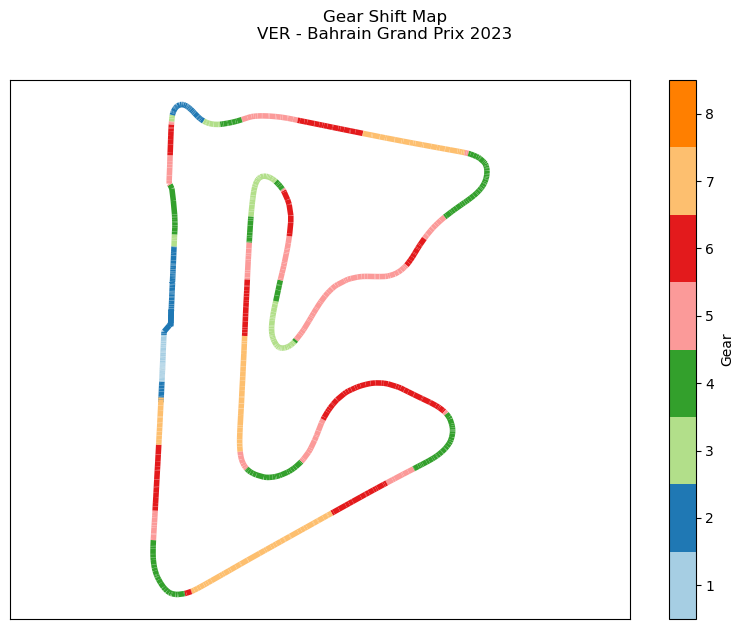

In [6]:
track_map = TrackMap(driver1)
track_map.plot_gear()

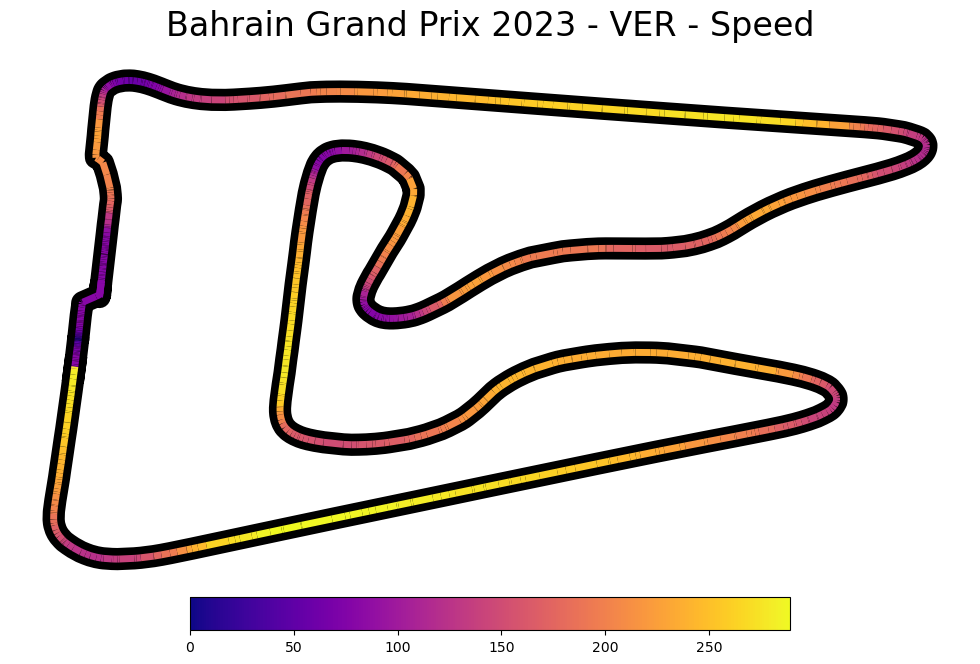

In [7]:
track_map = TrackMap(driver1)
track_map.plot_speed()

C:\Users\HP\anaconda3\Lib\site-packages\fastf1\plotting\_plotting.py:90: FutureWarning: FastF1 will no longer silently modify the default Matplotlib colors in the future.
To remove this warning, explicitly set `color_scheme=None` or `color_scheme='fastf1'` when calling `.setup_mpl()`.
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\fastf1\plotting\_plotting.py:98: FutureWarning: FastF1 will stop modifying the default Matplotlib settings in the future.
To opt-in to the new behaviour and remove this warning, explicitly set `misc_mpl_mods=False` when calling `.setup_mpl()`.
  warnings.warn(


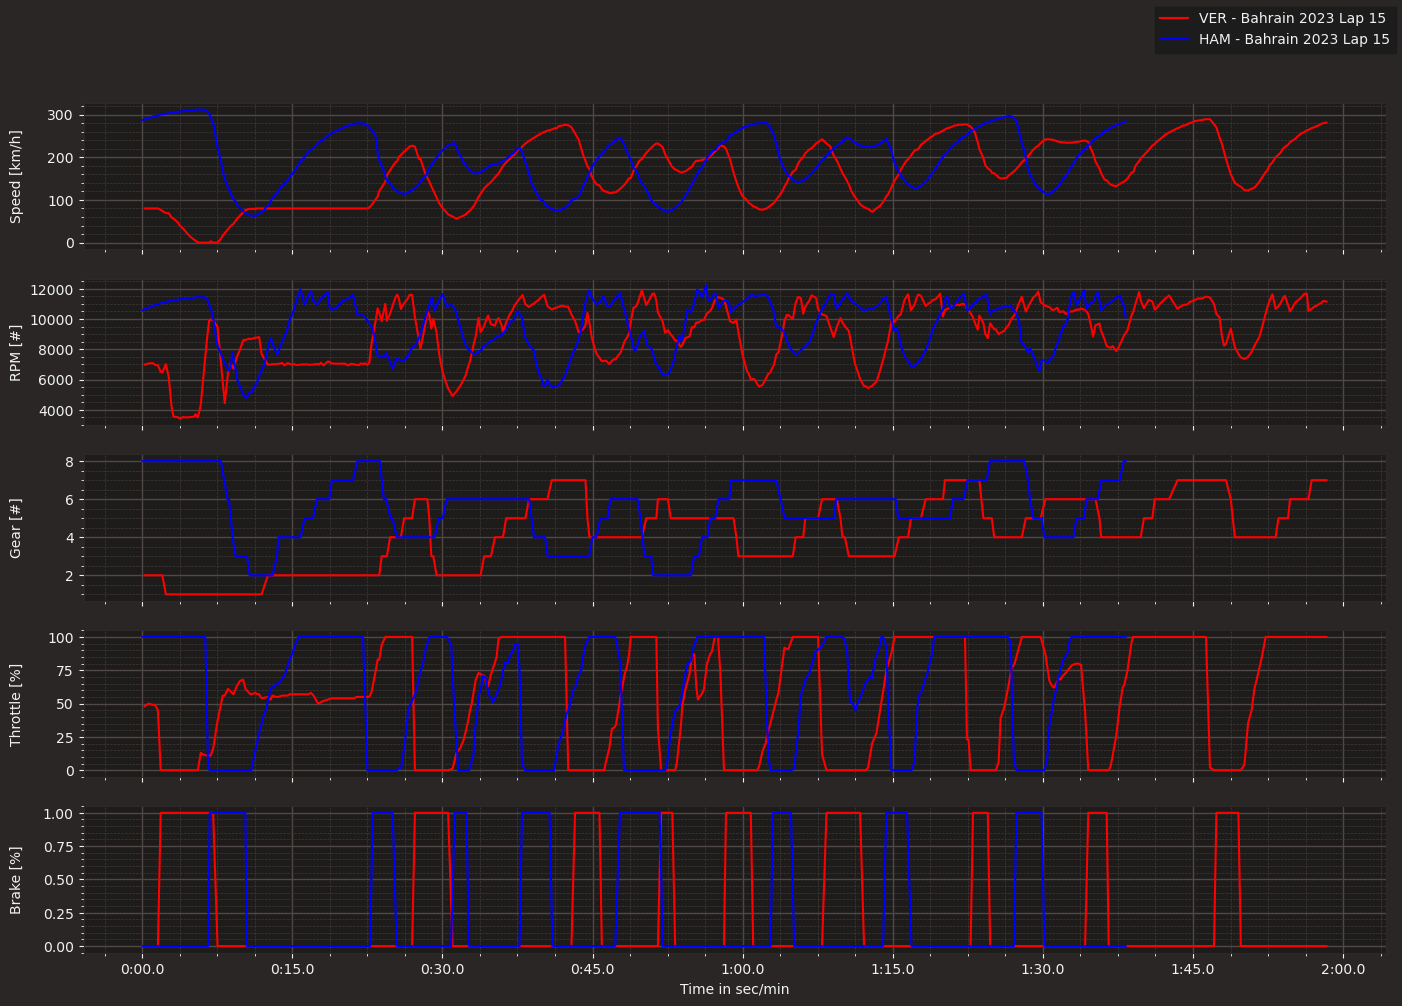

In [8]:
comparison = LapComparison(driver1, driver2)
comparison.plot_comparison()

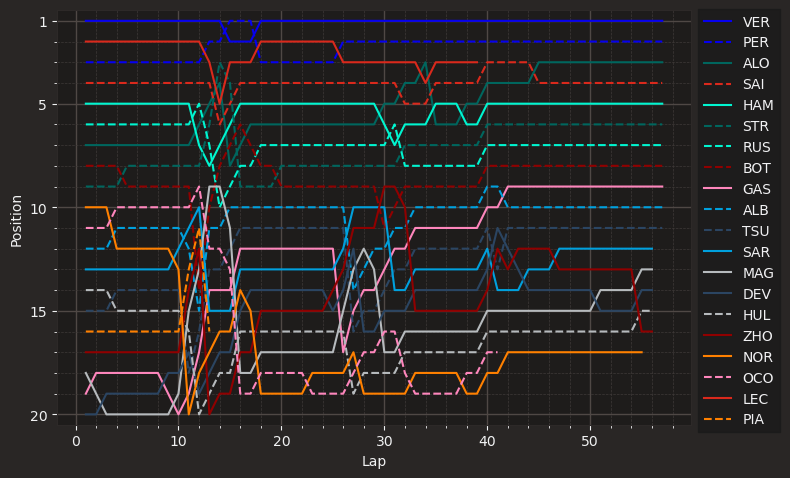

In [9]:
race_plot = RacePosition(2023, 'Bahrain', 'R')
race_plot.driver_positions()